In [1]:
!pip install pyspark

In [2]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import requests
import json

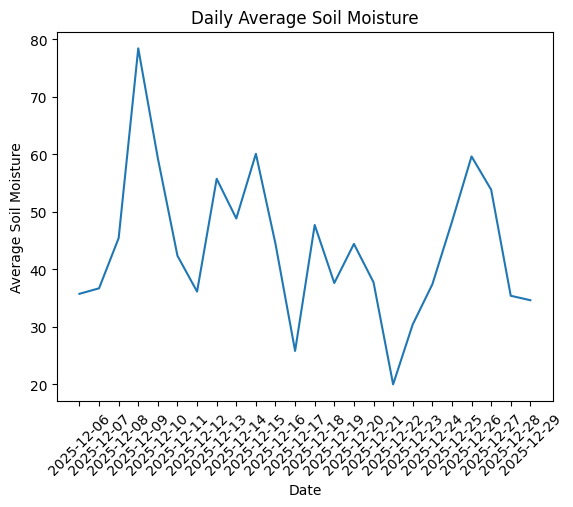

In [3]:
spark = SparkSession.builder.appName("Big Data").getOrCreate()
url = "https://raw.githubusercontent.com/Miron-Hanukaiev/Introduction_to_Cloud_Computing/refs/heads/main/json-20251229-2107.json"

response = requests.get(url)
with open("data.json", "w") as f:
    f.write(response.text)

# Big Data Graph
def big_data_graph():
  df=spark.read.json("data.json")
  #  keep only the timestamp and the sensor value
  df_clean = df.select(col("created_at"),col("value"))
  df_clean= df_clean.filter(col("value").isNotNull())
  rdd=df_clean.rdd
  # extract the date and the soil value from each record
  mapped = rdd.map(lambda row: (row["created_at"][:10], json.loads(row["value"])["soil"]))
  pairs = mapped.map(lambda x: (x[0], (x[1], 1)))
  reduced = pairs.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
  # calculate the daily average soil moisture
  avg_soil = reduced.mapValues(lambda x: x[0] / x[1])
  result = avg_soil.collect()
  # split the results into two lists for plotting
  dates = [x[0] for x in result]
  values = [x[1] for x in result]

  # create the graph
  plt.figure()
  plt.plot(dates, values)
  plt.xlabel("Date")
  plt.ylabel("Average Soil Moisture")
  plt.title("Daily Average Soil Moisture")
  plt.xticks(rotation=45)
  plt.show()

big_data_graph()